In [8]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import pandas as pd 
import requests
import json
import time
from konlpy.tag import Okt
from ckonlpy.tag import Twitter
from collections import Counter
from wordcloud import WordCloud
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [10]:
driver = webdriver.Chrome("C:\\Users\inter\Downloads\chromedriver.exe")

In [11]:
url = "http://www.chungnam.go.kr/coronaStatus.do"

In [12]:
driver.get(url)

In [13]:
bs = BeautifulSoup(driver.page_source, "html.parser") 

In [14]:
#데이터프레임 생성
columns=['환자','인적사항','감염경로','확진일','접촉자수','격리시설','이동경로']
df=pd.DataFrame(columns=columns)

In [15]:
datas=bs.find_all('td')

In [16]:
d_text=[]
for data in datas:
    d_text.append(data.get_text())

In [17]:
#def make_list(text,a_list):
n=0
환자=[]
인적사항,감염경로,확진일,접촉자수,격리시설,이동경로=[],[],[],[],[],[]

for text in d_text:
    n+=1
    if n%7==1:
        환자.append(text)
    elif n%7==2:
        인적사항.append(text)
    elif n%7==3:
        감염경로.append(text)
    elif n%7==4:
        확진일.append(text)
    elif n%7==5:
        접촉자수.append(text)
    elif n%7==6:
        격리시설.append(text)
    else :
        이동경로.append(text)
        


In [18]:
i=0
title=[환자,인적사항,감염경로,확진일,접촉자수,격리시설,이동경로]
for column in columns:
    df[column]=title[i]
    i+=1

In [19]:
HR=df['인적사항'].str.replace(',','').astype(str)

HR.dtypes

area,gender,age=[],[],[]
for hr in HR:
    hr_split=hr.split()
    area.append(hr_split[0])
    gender.append(hr_split[1])
    age.append(hr_split[2])

df['나이']=age
df['지역']=area
df['성별']=gender



In [20]:
#환자, 대분류 소분류 나누기
ID=df['환자'].str.replace(')','').astype(str)

ID.dtypes

High,Low=[],[]
for id in ID:
    id_split=id.split('(')
    High.append(id_split[0])
    Low.append(id_split[1])


df['대분류']=High
df['소분류']=Low



In [21]:
df.head()

,환자,인적사항,감염경로,확진일,접촉자수,격리시설,이동경로,나이,지역,성별,대분류,소분류
0,충남#102(천안#94),"천안(두정동), 여, 24세",역학조사중,3월 8일,역학조사중,천안의료원,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 코막힘 증상 , 3.8.(일)...",24세,천안(두정동),여,충남#102,천안#94
1,충남#101(천안#93),"천안(두정동), 여, 22세",역학조사중,3월 8일,역학조사중,천안의료원,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 기침, 인후통 증상 , 3.8...",22세,천안(두정동),여,충남#101,천안#93
2,충남#100(천안#92),"천안(두정동), 남, 54세",역학조사중,3월 8일,역학조사중,천안의료원,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 두통, 콧물 증상 , 3.8....",54세,천안(두정동),남,충남#100,천안#92
3,충남#99(천안#91),"천안(두정동), 여, 50세",역학조사중,3월 8일,역학조사중,천안의료원,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 무증상 , 3.7.(토) 천안...",50세,천안(두정동),여,충남#99,천안#91
4,충남#98(천안#90),"천안(백석동), 여, 20세",역학조사중,3월 7일,역학조사중,천안의료원,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 기침 증상, 2.24.(월) ...",20세,천안(백석동),여,충남#98,천안#90


In [14]:

#rout=df['이동경로'].tolist()
rout=df['이동경로'].str.replace('\t','').astype(str)
#rout=rout.str.replace('\n','').astype(str)
rout=rout.str.replace('\xa0','').astype(str)
rout=rout.str.replace('피트니스','휘트니스').astype(str)
rout=rout.str.replace('천안시','천안').astype(str)
rout=rout.str.replace('아산시','아산').astype(str)
rout=rout.str.replace('호반베르디움 센트로포레','호반베르디움센트로포레').astype(str)
rout=rout.str.replace('벽산블루밍 1차','벽산블루밍1차').astype(str)
rout=rout.str.replace('파크밸리 동일하이빌','파크밸리동일하이빌').astype(str)
rout=rout.str.replace('상쾌한 이비인후과','상쾌한이비인후과').astype(str)
rout=rout.str.replace('휘트니스 센터','휘트니스센터').astype(str)
rout_list=rout.tolist() #이동경로 데이터프레임 리스트로 변환

In [22]:
df['이동경로']=df['이동경로'].str.replace('\t','').astype(str)
#rout=rout.str.replace('\n','').astype(str)
df['이동경로']=df['이동경로'].str.replace('\xa0','').astype(str)
df['이동경로']=df['이동경로'].str.replace('피트니스','휘트니스').astype(str)
df['이동경로']=df['이동경로'].str.replace('천안시','천안').astype(str)
df['이동경로']=df['이동경로'].str.replace('아산시','아산').astype(str)
df['이동경로']=df['이동경로'].str.replace('호반베르디움 센트로포레','호반베르디움센트로포레').astype(str)
df['이동경로']=df['이동경로'].str.replace('벽산블루밍 1차','벽산블루밍1차').astype(str)
df['이동경로']=df['이동경로'].str.replace('파크밸리 동일하이빌','파크밸리동일하이빌').astype(str)
df['이동경로']=df['이동경로'].str.replace('상쾌한 이비인후과','상쾌한이비인후과').astype(str)
df['이동경로']=df['이동경로'].str.replace('휘트니스 센터','휘트니스센터').astype(str)
rout_list=df['이동경로'].tolist() #이동경로 데이터프레임 리스트로 변환

In [23]:
rout_list

['\n- 코막힘 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취, 3.8.(일) 확진 판정\n- 충남#3번(천안#2번)의 가족, 역학조사 中\n\n\n',
 '\n- 기침, 인후통 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취, 3.8.(일) 확진 판정\n- 충남#99,#100번(천안#91,#92번)의 가족, 역학조사 中\n\n\n',
 '\n- 두통, 콧물 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취, 3.8.(일) 확진 판정\n- 충남#99번(천안#91번)의 가족, 역학조사 中\n\n\n',
 '\n- 무증상 , 3.7.(토) 천안서북구보건소 선별진료소에서 검체 체취, 3.8.(일) 확진 판정\n- 충남#94번(천안#86번)의 접촉자, 역학조사 中\n\n\n',
 '\n- 기침 증상, 2.24.(월) 천안동남구보건소 선별진료소에서 검체 체취, 3.7.(토) 확진 판정\n- 역학조사 中\n\n\n',
 '\n- 무증상 증상, 3.5.(목) 천안서북구보건소 선별진료소에서 검체 체취, 3.7.(토) 확진 판정\n- 거주지 : 두정동 극동늘푸른(아), 충남#59번(천안#52번) 확진자의 수강생\n\n(3. 6.금) 자택거주\n(3. 7.토) 확진판정\n* 충남#59번 확진자의 수강생으로 자가격리 중 양성판정, 현장 역학조사 불필요\n',
 '\n- 인후통(기저질환) 증상, 3.6.(금) 천안동남구보건소 선별진료소에서 검체 체취, 3.7.(토) 확진 판정\n- 거주지 : 쌍용동 현대아이파크홈타운 1차, 충남#94번(천안#86번) 확진자의 가족\n\n(3.6.금) 천안 자택거주\n(3.7.토) 9:30-10:00 천안 동남구보건소 선별진료소에서 검진\n(3.7.토) 10:00- 천안 집에 머무름\n* 충남#94번 확진자의 영유아 자녀로 현장 역학조사 불필요\n',
 '\n- 기침, 오한, 근육통 증상, 3.7.(토) 천안동남구보건소 선별진료소에서 검체 체취, 3.7.(토) 확진 판정\n- 거주지 : 쌍용동 현대아

In [24]:
df['이동경로_편집']=rout_list

In [25]:
df.head()

,환자,인적사항,감염경로,확진일,접촉자수,격리시설,이동경로,나이,지역,성별,대분류,소분류,이동경로_편집
0,충남#102(천안#94),"천안(두정동), 여, 24세",역학조사중,3월 8일,역학조사중,천안의료원,"\n- 코막힘 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취, 3...",24세,천안(두정동),여,충남#102,천안#94,"\n- 코막힘 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취, 3..."
1,충남#101(천안#93),"천안(두정동), 여, 22세",역학조사중,3월 8일,역학조사중,천안의료원,"\n- 기침, 인후통 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체...",22세,천안(두정동),여,충남#101,천안#93,"\n- 기침, 인후통 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체..."
2,충남#100(천안#92),"천안(두정동), 남, 54세",역학조사중,3월 8일,역학조사중,천안의료원,"\n- 두통, 콧물 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취...",54세,천안(두정동),남,충남#100,천안#92,"\n- 두통, 콧물 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취..."
3,충남#99(천안#91),"천안(두정동), 여, 50세",역학조사중,3월 8일,역학조사중,천안의료원,"\n- 무증상 , 3.7.(토) 천안서북구보건소 선별진료소에서 검체 체취, 3.8....",50세,천안(두정동),여,충남#99,천안#91,"\n- 무증상 , 3.7.(토) 천안서북구보건소 선별진료소에서 검체 체취, 3.8...."
4,충남#98(천안#90),"천안(백석동), 여, 20세",역학조사중,3월 7일,역학조사중,천안의료원,"\n- 기침 증상, 2.24.(월) 천안동남구보건소 선별진료소에서 검체 체취, 3....",20세,천안(백석동),여,충남#98,천안#90,"\n- 기침 증상, 2.24.(월) 천안동남구보건소 선별진료소에서 검체 체취, 3...."


In [26]:
#워드클라우드 분석
text=''.join(rout_list)

twitter=Twitter()
twitter.add_dictionary(['행정복지센터','서비스센터','문화센터','휘트니스센터','상쾌한이비인후과','건양대병원','으로','삼성화재','수강생','코닝정밀소재','고속버스터미널','천안터미널','선영새마을금고','접촉자','순천향대학천안병원','현대아트빌라','현대로얄빌라','다가구주택','21세기병원','서울대정병원','파크밸리동일하이빌','대동다숲','성정동','두정동','지웰시티푸르지오','지웰푸르지오','지웰더샾','백석더샾','호반써밋플레잇센터시티','상아빌라','린스트라우스2차','벽산블루밍1차','호반베르디움센트로포레','태헌장미2차아파트','펜타폴리스','쌍용마을','용암마을','성성동','영성동','원성동','씨티자이','확진자','휘트니스','도보이동','쌍용동','동일하이빌','선별진료소','천안충무병원','하나로마트','자차이동','인후통','롯데마트','삼성라온내과','성정동','M정밀'], 'Noun') # 사전에 단어추가




nouns=twitter.nouns(text)

# 길이 하나 이상인 형태소만 리스트 담기
nouns=[n for n in nouns if len(n)>1]


# 불용어 처리
stop_words=''
stop_words=stop_words.split(' ')

filter_nouns=[n for n in nouns if n not in stop_words]        
        
# 명사만 빈도수 추출(상위 100개)
count=Counter(filter_nouns)
tags=count.most_common(100)

print(tags)


C:\Users\inter\AppData\Local\Programs\Python\Python37\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


[('천안', 822), ('접촉자', 220), ('선별진료소', 167), ('자택', 147), ('보건소', 137), ('판정', 137), ('충남', 117), ('서북구', 113), ('확진', 110), ('확진자', 108), ('검체', 101), ('아산', 100), ('거주', 97), ('거주지', 93), ('체취', 90), ('조사', 87), ('불당동', 73), ('증상', 68), ('역학', 67), ('가족', 56), ('종일', 56), ('수강생', 54), ('귀가', 46), ('약국', 43), ('백석동', 43), ('성정동', 43), ('동남구', 40), ('자가', 37), ('격리', 37), ('검사', 37), ('무증상', 34), ('두정동', 33), ('쌍용동', 31), ('양성', 27), ('현장', 27), ('필요', 27), ('단지', 26), ('불당', 26), ('백석', 25), ('발열', 24), ('병원', 20), ('인후통', 19), ('출근', 18), ('직원', 18), ('쌍용', 17), ('택시', 17), ('마트', 17), ('아이파크', 16), ('봉명동', 16), ('승차', 16), ('천안의료원', 16), ('부산', 16), ('기침', 15), ('운행', 15), ('계룡', 15), ('자녀', 13), ('근육통', 13), ('문화센터', 13), ('순천향대', 13), ('수강', 12), ('채취', 12), ('배방읍', 12), ('휘트니스센터', 12), ('새마을금고', 12), ('천안충무병원', 11), ('으로', 11), ('이비인후과', 11), ('이마트', 11), ('마스크', 11), ('착용', 11), ('푸르지오', 10), ('탕정면', 10), ('버스', 10), ('외부', 10), ('아파트', 10), ('휘트니스', 10), ('콧물', 9), ('식당', 9), ('

In [27]:
for t in rout_list:
    if "정밀" in t:
        print(t)


- 2.25.(화) 인후통 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.4.(수) 확진 판정
- 거주지 : 백석동 백석더샾, 충남#86,#87,#88번(천안#78,#79,#80번) 확진자의 가족, 역학조사 中

(2.24.월) 종 일  천안 자택 거주  - 접촉자 3명
(2.25.화) 18:30~18:34 천안 상쾌한이비인후과의원(오성로1, 두정동) – 접촉자 1명
(2.25.화) 18:35~18:37 천안 맘편한 약국(오성로1, 두정동)
(2.25.화) 18:40~18:44 천안 천안한우축산(한들3호 78-23, 백석동)
(2.25.화) 18:45~19:00 천안 자택으로 이동
(2.26.수) 종 일   천안 자택 거주
(2.27.목) 05:45~15:30 아산 코닝정밀소재(탕정면, 2단지, 출근) - 접촉자 1명
(2.28.금) 05:45~15:30 아산 코닝정밀소재(탕정면, 2단지, 출근) - 접촉자 2명
(2.29.토) 06:14~15:30 아산 코닝정밀소재(탕정면, 2단지, 출근) - 접촉자 2명
(3. 1.일) 05:45~19:00 아산 코닝정밀소재(탕정면, 2단지, 출근) - 접촉자 1명
(3. 2.월) 05:45~11:00 아산 코닝정밀소재(탕정면, 2단지, 출근)
(3. 2.월) 11:00~11:47 천안 플러스 이비인후과(두정동) - 접촉자 1명
(3. 2.월) 11:47~12:05 천안 한성약국(두정동)
(3. 2.월) 12:05~12:26 천안 서북구 보건소 드라이브스루 선별진료소 



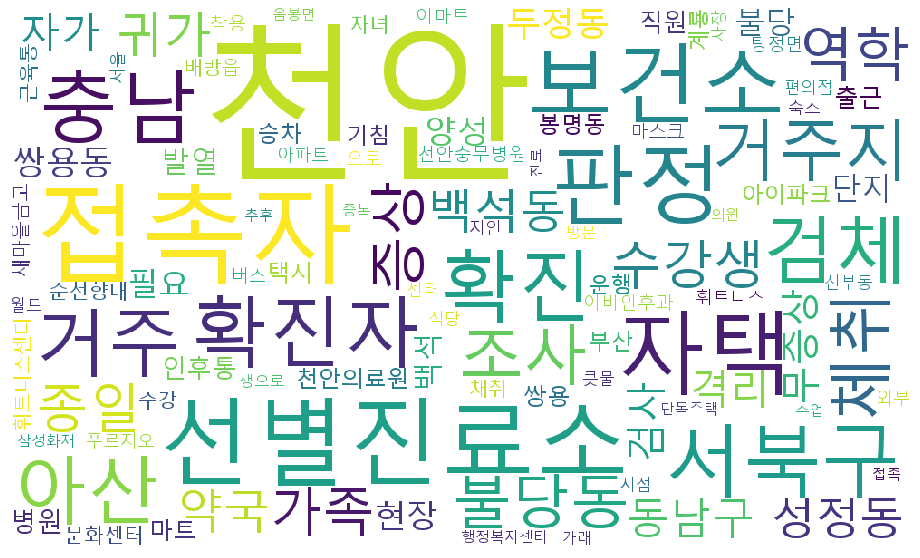

In [28]:
#워드클라우드 그리기

wordcloud=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',background_color='white',width=1000,height=600).generate_from_frequencies(dict(tags))

fig=plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [79]:
patient=df['소분류']

twitter=Twitter()
twitter.add_dictionary(['행정복지센터','서비스센터','문화센터','휘트니스센터','상쾌한이비인후과','건양대병원','으로','삼성화재','수강생','코닝정밀소재','고속버스터미널','천안터미널','선영새마을금고','접촉자','순천향대학천안병원','현대아트빌라','현대로얄빌라','다가구주택','21세기병원','서울대정병원','파크밸리동일하이빌','대동다숲','성정동','두정동','지웰시티푸르지오','지웰푸르지오','지웰더샾','백석더샾','호반써밋플레잇센터시티','상아빌라','린스트라우스2차','벽산블루밍1차','호반베르디움센트로포레','태헌장미2차아파트','펜타폴리스','쌍용마을','용암마을','성성동','영성동','원성동','씨티자이','확진자','휘트니스','도보이동','쌍용동','동일하이빌','선별진료소','천안충무병원','하나로마트','자차이동','인후통','롯데마트','삼성라온내과','성정동','M정밀'], 'Noun') # 사전에 단어추가


def filter_text(a):
    text1=df[df.소분류==a]['경로'].tolist()
    text2=''.join(text1)
    nouns=twitter.nouns(text2)

    # 길이 하나 이상인 형태소만 리스트 담기
    nouns=[n for n in nouns if len(n)>1]

    # 불용어 처리
    stop_words='으로 생으로 경천'
    stop_words=stop_words.split(' ')

    filter_nouns=[n for n in nouns if n not in stop_words]        

    return filter_nouns


record=[]
for who in patient:
    a=filter_text(who)
    for person in a:
        record.append((who,person))    

record




[('천안#89', '자택'),
 ('천안#89', '거주'),
 ('천안#89', '확진'),
 ('천안#89', '판정'),
 ('천안#89', '충남'),
 ('천안#89', '확진자'),
 ('천안#89', '수강'),
 ('천안#89', '자가'),
 ('천안#89', '격리'),
 ('천안#89', '양성'),
 ('천안#89', '판정'),
 ('천안#89', '현장'),
 ('천안#89', '역학'),
 ('천안#89', '조사'),
 ('천안#89', '필요'),
 ('천안#88', '천안'),
 ('천안#88', '자택'),
 ('천안#88', '거주'),
 ('천안#88', '천안'),
 ('천안#88', '동남구'),
 ('천안#88', '보건소'),
 ('천안#88', '선별진료소'),
 ('천안#88', '검진'),
 ('천안#88', '천안'),
 ('천안#88', '충남'),
 ('천안#88', '확진자'),
 ('천안#88', '영유'),
 ('천안#88', '자녀'),
 ('천안#88', '현장'),
 ('천안#88', '역학'),
 ('천안#88', '조사'),
 ('천안#88', '필요'),
 ('천안#87', '천안'),
 ('천안#87', '자택'),
 ('천안#87', '출발'),
 ('천안#87', '천안'),
 ('천안#87', '여동생'),
 ('천안#87', '접촉자'),
 ('천안#87', '천안'),
 ('천안#87', '동남구'),
 ('천안#87', '신청'),
 ('천안#87', '별관'),
 ('천안#87', '접촉자'),
 ('천안#87', '천안'),
 ('천안#87', '실크로드'),
 ('천안#87', '동남구'),
 ('천안#87', '충절'),
 ('천안#87', '접촉자'),
 ('천안#87', '천안'),
 ('천안#87', '동남구'),
 ('천안#87', '신청'),
 ('천안#87', '별관'),
 ('천안#87', '천안'),
 ('천안#87', '부모님'),
 ('천안#87', 

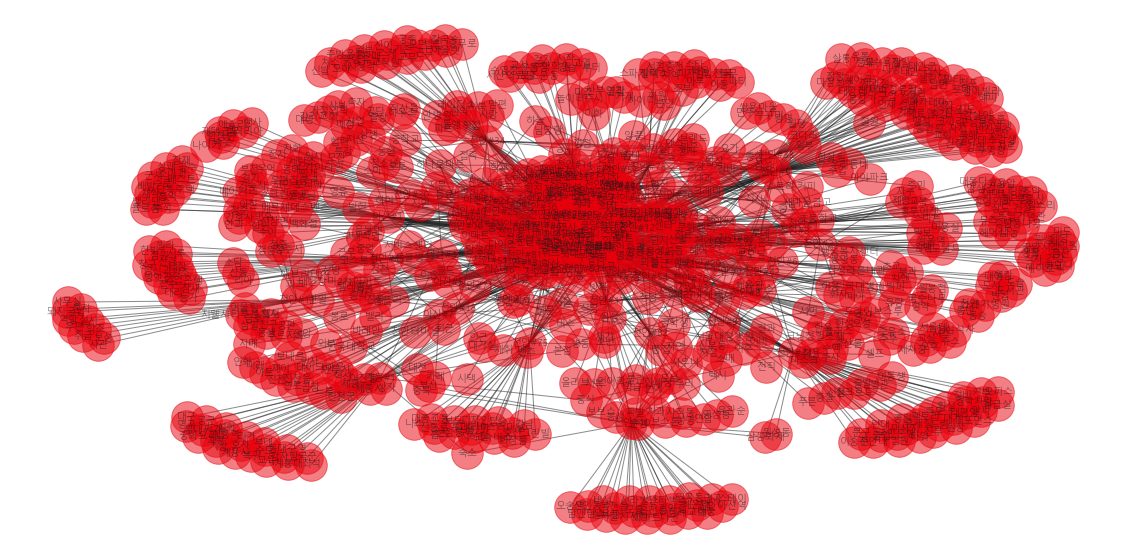

In [81]:
#네트워크 분석으로 연관점 찾기
# http://blog.daum.net/geoscience/1408 참조


#font_path="c:/Windows/Fonts/malgun.ttf"
#font_name=fm.FontProperties(fname=font_path).get_name()
#rc=('font', font_family=font_name)



plt.figure(figsize=(20,10))
plt.axis('off')
G=nx.Graph()
#pos=nx.random_layout(G)
#pos=nx.planar_layout(G)
pos=nx.spring_layout(G)
#G.add_edge(1,2)
#G.add_node('천안#87')




G.add_edges_from(record)
#G.nodes()
nx.draw_networkx(G, node_size=1000, font_size=10, font_family=font_name, node_color='R',alpha=0.5)#, with_lables=True
plt.show()

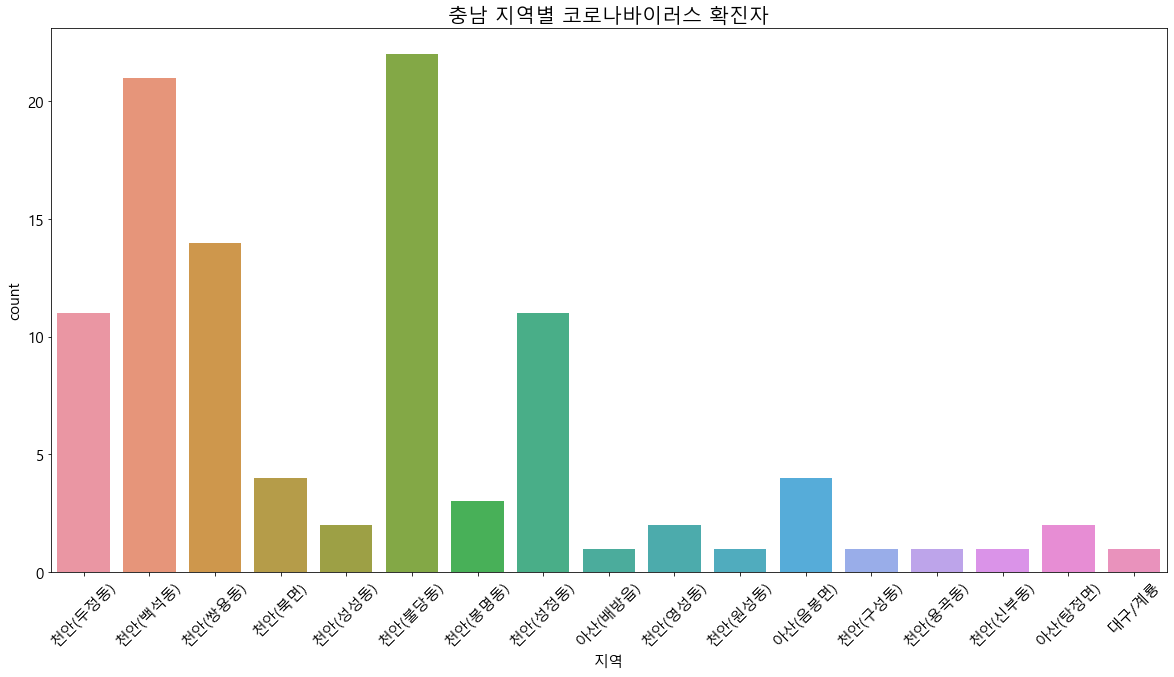

In [30]:
%matplotlib inline

plt.figure(figsize=(20,10))

plt.title('충남 지역별 코로나바이러스 확진자', fontsize=20)
plt.xticks(fontsize=15,rotation=45)
plt.yticks(fontsize=15)
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)
#plt.legend(fontsize=15)
sns.countplot(x=df["지역"],data=df)

In [31]:
# 확진일 시계열 변수로 변환
# 나이 연령대 추가
df['나이']=df['나이'].str.replace('세','')  #1회만 실행 #.astype(int) 
df['나이']=df['나이'].str.replace('대','')   #1회만 실행
df['나이']=df['나이'].astype(int)    #1회만 실행
df['연령대']=(df['나이']//10)*10
#df['연령대'].apply(lambda x:(df['나이']//10)*10)


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 14 columns):
환자         102 non-null object
인적사항       102 non-null object
감염경로       102 non-null object
확진일        102 non-null object
접촉자수       102 non-null object
격리시설       102 non-null object
이동경로       102 non-null object
나이         102 non-null int32
지역         102 non-null object
성별         102 non-null object
대분류        102 non-null object
소분류        102 non-null object
이동경로_편집    102 non-null object
연령대        102 non-null int32
dtypes: int32(2), object(12)
memory usage: 10.4+ KB


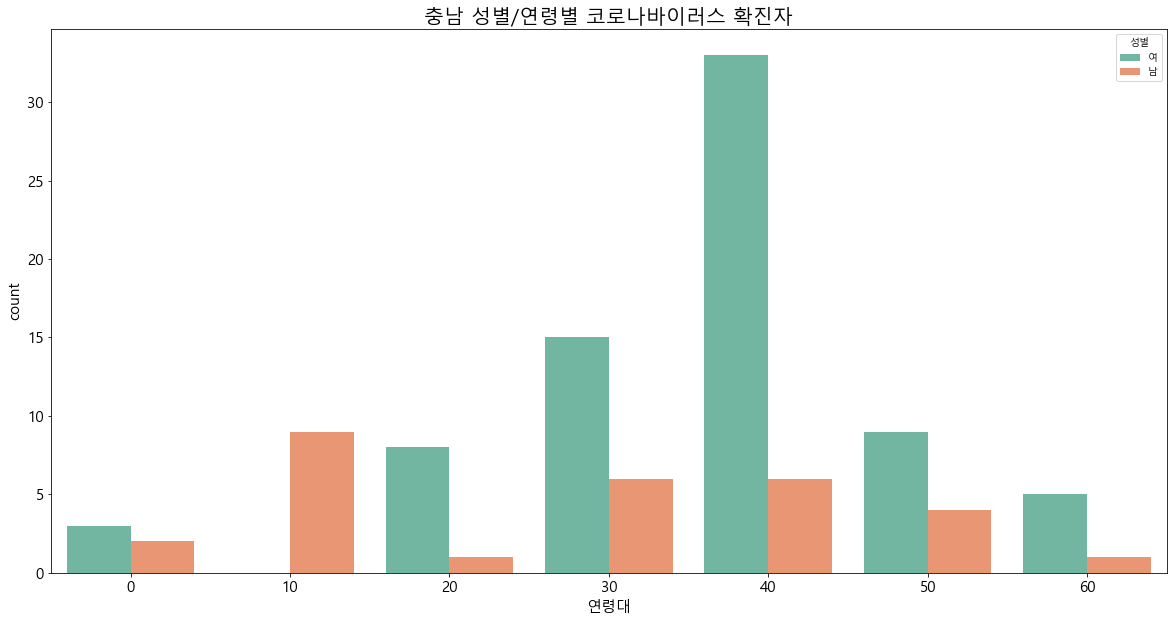

In [33]:
import seaborn as sns
plt.figure(figsize=(20,10))
plt.title('충남 성별/연령별 코로나바이러스 확진자', fontsize=20)
plt.xticks(fontsize=15,rotation=0)
plt.yticks(fontsize=15)
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)
sns.set_context(font_scale=15)
sns.set_color_codes(palette='bright')
sns.countplot(x=df["연령대"],hue='성별',data=df, palette='Set2')

In [34]:
splt=df['이동경로_편집'].tolist()

In [36]:
home,way=[],[]
for sp in splt:
    spp=sp.split('\n\n')
    home.append(spp[0])
    way.append(spp[1])    

In [37]:
df['증상_거주지']=home
df['경로']=way

In [38]:
df.head(5)

,환자,인적사항,감염경로,확진일,접촉자수,격리시설,이동경로,나이,지역,성별,대분류,소분류,이동경로_편집,연령대,증상_거주지,경로
0,충남#102(천안#94),"천안(두정동), 여, 24세",역학조사중,3월 8일,역학조사중,천안의료원,"\n- 코막힘 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취, 3...",24,천안(두정동),여,충남#102,천안#94,"\n- 코막힘 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취, 3...",20,"\n- 코막힘 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취, 3...",\n
1,충남#101(천안#93),"천안(두정동), 여, 22세",역학조사중,3월 8일,역학조사중,천안의료원,"\n- 기침, 인후통 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체...",22,천안(두정동),여,충남#101,천안#93,"\n- 기침, 인후통 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체...",20,"\n- 기침, 인후통 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체...",\n
2,충남#100(천안#92),"천안(두정동), 남, 54세",역학조사중,3월 8일,역학조사중,천안의료원,"\n- 두통, 콧물 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취...",54,천안(두정동),남,충남#100,천안#92,"\n- 두통, 콧물 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취...",50,"\n- 두통, 콧물 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취...",\n
3,충남#99(천안#91),"천안(두정동), 여, 50세",역학조사중,3월 8일,역학조사중,천안의료원,"\n- 무증상 , 3.7.(토) 천안서북구보건소 선별진료소에서 검체 체취, 3.8....",50,천안(두정동),여,충남#99,천안#91,"\n- 무증상 , 3.7.(토) 천안서북구보건소 선별진료소에서 검체 체취, 3.8....",50,"\n- 무증상 , 3.7.(토) 천안서북구보건소 선별진료소에서 검체 체취, 3.8....",\n
4,충남#98(천안#90),"천안(백석동), 여, 20세",역학조사중,3월 7일,역학조사중,천안의료원,"\n- 기침 증상, 2.24.(월) 천안동남구보건소 선별진료소에서 검체 체취, 3....",20,천안(백석동),여,충남#98,천안#90,"\n- 기침 증상, 2.24.(월) 천안동남구보건소 선별진료소에서 검체 체취, 3....",20,"\n- 기침 증상, 2.24.(월) 천안동남구보건소 선별진료소에서 검체 체취, 3....",\n


In [39]:
snr=df['증상_거주지'].tolist()


In [50]:
#확진일 시계열 데이터 변환
df['확진일']=df['확진일'].str.replace('월','-')#.astype('datetime64') #한번만 사용
df['확진일']=df['확진일'].str.replace('일','')   #한번만 사용
df['확진일']=df['확진일'].str.replace(' ','')    #한번만 사용

if '2020-' in df['확진일'].iloc[0]:  
    df['확진일']=df['확진일'].astype('datetime64')
        
else: df['확진일']="2020-"+df['확진일']

df.head(10)

,환자,인적사항,감염경로,확진일,접촉자수,격리시설,이동경로,나이,지역,성별,대분류,소분류,이동경로_편집,연령대,증상_거주지,경로,확진자수
0,충남#102(천안#94),"천안(두정동), 여, 24세",역학조사중,2020-03-08,역학조사중,천안의료원,"\n- 코막힘 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취, 3...",24,천안(두정동),여,충남#102,천안#94,"\n- 코막힘 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취, 3...",20,"\n- 코막힘 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취, 3...",\n,1
1,충남#101(천안#93),"천안(두정동), 여, 22세",역학조사중,2020-03-08,역학조사중,천안의료원,"\n- 기침, 인후통 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체...",22,천안(두정동),여,충남#101,천안#93,"\n- 기침, 인후통 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체...",20,"\n- 기침, 인후통 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체...",\n,1
2,충남#100(천안#92),"천안(두정동), 남, 54세",역학조사중,2020-03-08,역학조사중,천안의료원,"\n- 두통, 콧물 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취...",54,천안(두정동),남,충남#100,천안#92,"\n- 두통, 콧물 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취...",50,"\n- 두통, 콧물 증상 , 3.8.(일) 천안서북구보건소 선별진료소에서 검체 체취...",\n,1
3,충남#99(천안#91),"천안(두정동), 여, 50세",역학조사중,2020-03-08,역학조사중,천안의료원,"\n- 무증상 , 3.7.(토) 천안서북구보건소 선별진료소에서 검체 체취, 3.8....",50,천안(두정동),여,충남#99,천안#91,"\n- 무증상 , 3.7.(토) 천안서북구보건소 선별진료소에서 검체 체취, 3.8....",50,"\n- 무증상 , 3.7.(토) 천안서북구보건소 선별진료소에서 검체 체취, 3.8....",\n,1
4,충남#98(천안#90),"천안(백석동), 여, 20세",역학조사중,2020-03-07,역학조사중,천안의료원,"\n- 기침 증상, 2.24.(월) 천안동남구보건소 선별진료소에서 검체 체취, 3....",20,천안(백석동),여,충남#98,천안#90,"\n- 기침 증상, 2.24.(월) 천안동남구보건소 선별진료소에서 검체 체취, 3....",20,"\n- 기침 증상, 2.24.(월) 천안동남구보건소 선별진료소에서 검체 체취, 3....",\n,1
5,충남#97(천안#89),"천안(두정동), 여, 47세",역학분석중,2020-03-07,0명,천안의료원,"\n- 무증상 증상, 3.5.(목) 천안서북구보건소 선별진료소에서 검체 체취, 3....",47,천안(두정동),여,충남#97,천안#89,"\n- 무증상 증상, 3.5.(목) 천안서북구보건소 선별진료소에서 검체 체취, 3....",40,"\n- 무증상 증상, 3.5.(목) 천안서북구보건소 선별진료소에서 검체 체취, 3....",(3. 6.금) 자택거주\n(3. 7.토) 확진판정\n* 충남#59번 확진자의 수강...,1
6,충남#96(천안#88),"천안(쌍용동), 여, 3세",충남#94번 확진자,2020-03-07,0명,홍성의료원,"\n- 인후통(기저질환) 증상, 3.6.(금) 천안동남구보건소 선별진료소에서 검체 ...",3,천안(쌍용동),여,충남#96,천안#88,"\n- 인후통(기저질환) 증상, 3.6.(금) 천안동남구보건소 선별진료소에서 검체 ...",0,"\n- 인후통(기저질환) 증상, 3.6.(금) 천안동남구보건소 선별진료소에서 검체 ...",(3.6.금) 천안 자택거주\n(3.7.토) 9:30-10:00 천안 동남구보건소 ...,1
7,충남#95(천안#87),"천안(쌍용동), 여, 32세",역학조사중,2020-03-07,33명,홍성의료원,"\n- 기침, 오한, 근육통 증상, 3.7.(토) 천안동남구보건소 선별진료소에서 검...",32,천안(쌍용동),여,충남#95,천안#87,"\n- 기침, 오한, 근육통 증상, 3.7.(토) 천안동남구보건소 선별진료소에서 검...",30,"\n- 기침, 오한, 근육통 증상, 3.7.(토) 천안동남구보건소 선별진료소에서 검...",(3. 5.목) 08:30∼ 천안 자택 출발\n(3. 5.목) 수 시 천안 여동생 ...,1
8,충남#94(천안#86),"천안(쌍용동), 남, 38세",역학조사중,2020-03-06,78명,천안의료원,"\n- 발열, 상기도 감염 증상, 3.6.(금) 천안충무병원 선별진료소에서 검체 체...",38,천안(쌍용동),남,충남#94,천안#86,"\n- 발열, 상기도 감염 증상, 3.6.(금) 천안충무병원 선별진료소에서 검체 체...",30,"\n- 발열, 상기도 감염 증상, 3.6.(금) 천안충무병원 선별진료소에서 검체 체...",(2.29.토) 종 일 천안 자택 거주\n(3. 1.일) 13:50∼13:51 천안...,1
9,충남#93(천안#85),"천안(백석동), 여, 31세",충남#50번 확진자,2020-03-06,0명,천안의료원,"\n- 기침, 인후통 증상, 3.6.(금) 천안서북구보건소 승차선별진료소에서 검체 ...",31,천안(백석동),여,충남#93,천안#85,"\n- 기침, 인후통 증상, 3.6.(금) 천안서북구보건소 승차선별진료소에서 검체 ...",30,"\n- 기침, 인후통 증상, 3.6.(금) 천안서북구보건소 승차선별진료소에서 검체 ...",(3.4.수~3.5.목) 천안 자택거주\n(3.6.금) 천안 서북구보건소 승차선별진...,1


In [41]:
df.info()
df['확진자수']=1
df_time=df.groupby(['지역','확진일']).sum()
df_time=df_time.reset_index()
df_time.sort_values('확진일',axis=0, ascending = True,inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 16 columns):
환자         102 non-null object
인적사항       102 non-null object
감염경로       102 non-null object
확진일        102 non-null object
접촉자수       102 non-null object
격리시설       102 non-null object
이동경로       102 non-null object
나이         102 non-null int32
지역         102 non-null object
성별         102 non-null object
대분류        102 non-null object
소분류        102 non-null object
이동경로_편집    102 non-null object
연령대        102 non-null int32
증상_거주지     102 non-null object
경로         102 non-null object
dtypes: int32(2), object(14)
memory usage: 12.0+ KB


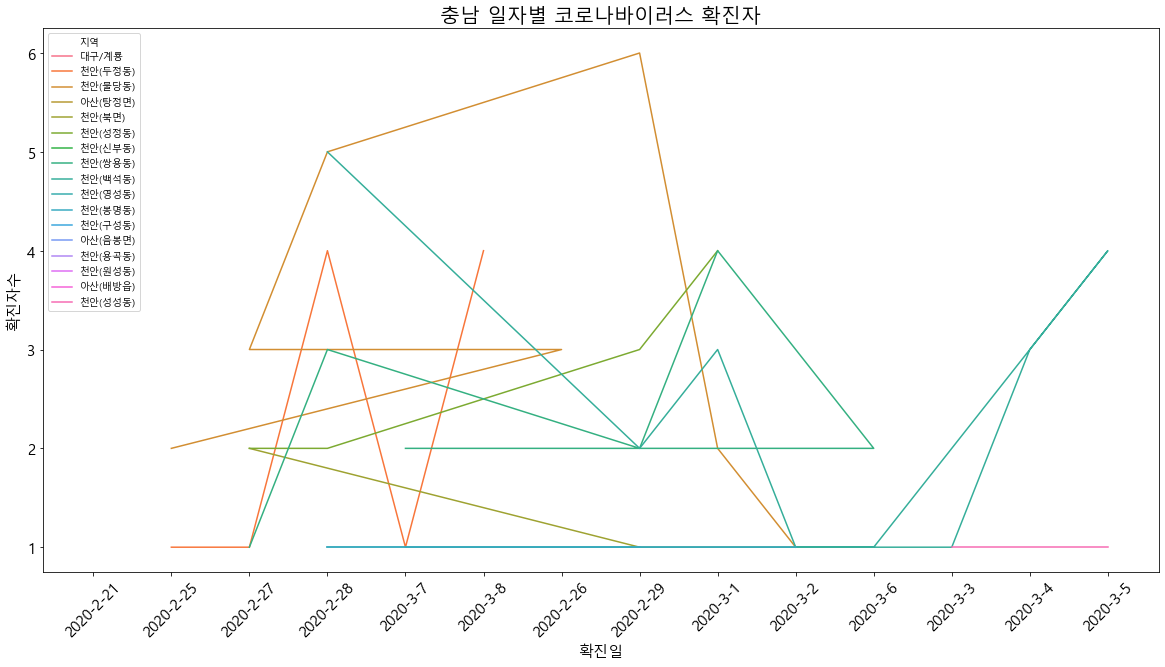

In [42]:
%matplotlib inline

plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(20,10))
plt.title('충남 일자별 코로나바이러스 확진자', fontsize=20)
plt.xticks(fontsize=15,rotation=45)
#plt.xlim('2020-02-20','2020-03-15')
plt.yticks(fontsize=15)
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)
#sns.set_context(font_scale=15)
sns.set_color_codes(palette='bright')

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '+', 'X','.','1','_')

sns.lineplot(x='확진일',y='확진자수',hue='지역',dashes=False, markers=True, data=df_time)#,style='지역'
plt.show()

In [43]:
#증상 워드클라우드 분석

text=''.join(df['증상_거주지'].tolist())

twitter=Twitter()
twitter.add_dictionary(['행정복지센터','순천향대학천안병원','현대아트빌라','현대로얄빌라','다가구주택','21세기병원','서울대정병원','파크밸리동일하이빌','대동다숲','성정동','두정동','지웰시티푸르지오','지웰푸르지오','지웰더샾','백석더샾','호반써밋플레잇센터시티','상아빌라','린스트라우스2차','벽산블루밍1차','호반베르디움센트로포레','태헌장미2차아파트','펜타폴리스','쌍용마을','용암마을','성성동','영성동','원성동','씨티자이','확진자','휘트니스','도보이동','쌍용동','동일하이빌','선별진료소','천안충무병원','하나로마트','자차이동','인후통','롯데마트','삼성라온내과','성정동','M정밀'], 'Noun') # 사전에 단어추가


nouns=twitter.nouns(text)

# 길이 하나 이상인 형태소만 리스트 담기
nouns=[n for n in nouns if len(n)>1]


# 불용어 처리
stop_words=''
stop_words=stop_words.split(' ')

filter_nouns=[n for n in nouns if n not in stop_words]        
        
# 명사만 빈도수 추출(상위 100개)
count=Counter(filter_nouns)
tags=count.most_common(100)

print(tags)

C:\Users\inter\AppData\Local\Programs\Python\Python37\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


[('천안', 151), ('확진', 102), ('판정', 102), ('검체', 101), ('선별진료소', 100), ('거주지', 93), ('체취', 90), ('충남', 90), ('확진자', 89), ('보건소', 77), ('증상', 66), ('서북구', 56), ('가족', 42), ('수강생', 42), ('조사', 41), ('역학', 40), ('무증상', 34), ('접촉', 27), ('발열', 24), ('불당동', 23), ('아산', 22), ('인후통', 19), ('동남구', 18), ('기침', 15), ('근육통', 13), ('백석동', 13), ('아이파크', 12), ('채취', 11), ('성정동', 11), ('쌍용동', 10), ('단지', 10), ('콧물', 9), ('백석', 9), ('천안의료원', 9), ('외부', 9), ('푸르지오', 8), ('천안충무병원', 7), ('가래', 7), ('두통', 6), ('두정동', 6), ('오한', 6), ('승차', 6), ('단독주택', 6), ('파크밸리동일하이빌', 6), ('순천향대', 6), ('대동다숲', 5), ('기타', 5), ('현대', 4), ('타운', 4), ('북면', 4), ('백석더샾', 4), ('대타', 4), ('강사', 4), ('강습', 4), ('로부터', 4), ('수업', 4), ('쌍용', 4), ('일반', 4), ('발병', 4), ('병원', 4), ('주택', 3), ('봉명동', 3), ('상아빌라', 3), ('쌍용마을', 2), ('단국대병원', 2), ('상가', 2), ('근무', 2), ('감기', 2), ('벽산블루밍1차', 2), ('호반베르디움센트로포레', 2), ('학교', 2), ('안병원', 2), ('빌라', 2), ('미열', 2), ('지웰시티푸르지오', 2), ('영성동', 2), ('펜타폴리스', 2), ('파트', 2), ('태헌장미2차아파트', 2), ('아파트', 2)

In [44]:
q=0
for t in df['증상_거주지'].tolist():
    if '센터' in t:
        #q=1+q
        print(t)
print(q)


- 2.27.(목) 무증상, 2.27.(목) 천안서북구보건소 선별진료소에서 검체 체취, 2.28.(금) 확진 판정
- 거주지 : 태헌장미2차아파트, 월드JNK휘트니스센터 수강, 역학조사 中

- 2.27.(목) 발열, 기침 증상, 2.27.(목) 천안서북구보건소 선별진료소에서 검체 체취, 2.28.(금) 확진 판정
- 거주지 : 불당동 호반써밋플레잇센터시티, 충남#11번(천안#8번) 확진자의 가족, 역학조사 中

- 2.25.(화) 두통, 오한 증상, 2.26.(수) 천안서부구보건소에서 검체 체취, 2.27.(목) 확진 판정
- 거주지 : 불당동 아이파크, 충남#8번(천안#5번) 확진자의 수강생(2.20.목 불당동 아이파크 휘트니스센터 줌바댄스 수강)
0


In [45]:
#증상 워드클라우드 분석

text1=''.join(df['경로'].tolist())

twitter=Twitter()
twitter.add_dictionary(['행정복지센터','서비스센터','문화센터','휘트니스센터','상쾌한이비인후과','건양대병원','으로','삼성화재','수강생','코닝정밀소재','고속버스터미널','천안터미널','선영새마을금고','접촉자','순천향대학천안병원','현대아트빌라','현대로얄빌라','다가구주택','21세기병원','서울대정병원','파크밸리동일하이빌','대동다숲','성정동','두정동','지웰시티푸르지오','지웰푸르지오','지웰더샾','백석더샾','호반써밋플레잇센터시티','상아빌라','린스트라우스2차','벽산블루밍1차','호반베르디움센트로포레','태헌장미2차아파트','펜타폴리스','쌍용마을','용암마을','성성동','영성동','원성동','씨티자이','확진자','휘트니스','도보이동','쌍용동','동일하이빌','선별진료소','천안충무병원','하나로마트','자차이동','인후통','롯데마트','삼성라온내과','성정동','M정밀'], 'Noun') # 사전에 단어추가
              
               
nouns=twitter.nouns(text1)

# 길이 하나 이상인 형태소만 리스트 담기
nouns=[n for n in nouns if len(n)>1]


# 불용어 처리
stop_words='으로 생으로 경천'
stop_words=stop_words.split(' ')

filter_nouns=[n for n in nouns if n not in stop_words]        
        
# 명사만 빈도수 추출(상위 100개)
count=Counter(filter_nouns)
tags=count.most_common(100)

print(tags)

[('천안', 671), ('접촉자', 197), ('자택', 147), ('거주', 97), ('아산', 78), ('선별진료소', 67), ('보건소', 60), ('서북구', 57), ('종일', 56), ('불당동', 50), ('조사', 46), ('귀가', 46), ('약국', 43), ('자가', 37), ('격리', 37), ('검사', 37), ('판정', 35), ('성정동', 32), ('백석동', 30), ('충남', 27), ('양성', 27), ('현장', 27), ('역학', 27), ('필요', 27), ('두정동', 27), ('불당', 25), ('동남구', 22), ('쌍용동', 21), ('확진자', 19), ('출근', 18), ('택시', 17), ('마트', 17), ('직원', 17), ('백석', 16), ('단지', 16), ('병원', 16), ('부산', 16), ('운행', 15), ('계룡', 15), ('가족', 14), ('자녀', 13), ('봉명동', 13), ('쌍용', 13), ('문화센터', 13), ('배방읍', 12), ('새마을금고', 12), ('수강생', 12), ('이비인후과', 11), ('이마트', 11), ('마스크', 11), ('착용', 11), ('수강', 10), ('승차', 10), ('버스', 10), ('휘트니스', 10), ('휘트니스센터', 10), ('식당', 9), ('센터', 9), ('편의점', 9), ('서울', 9), ('지인', 9), ('사장', 9), ('지점', 9), ('숙소', 9), ('확진', 8), ('탕정면', 8), ('신부동', 8), ('방문', 8), ('아파트', 8), ('월드', 8), ('행정복지센터', 7), ('천안의료원', 7), ('의원', 7), ('순천향대', 7), ('삼성화재', 7), ('추후', 7), ('음봉면', 7), ('중복', 7), ('신방동', 6), ('상쾌한이비인후과', 6), ('고속버

In [46]:
q=0
for t in df['경로'].tolist():
    if '행정' in t:
        #q=1+q
        print(t)
print(q)

(2.29.토) 종 일 천안 자택 거주
(3. 1.일) 13:50∼13:51 천안 참좋은 약국(쌍용동)
(3. 2.월) 08:50∼12:00 천안 봉명동 행정복지센터(봉명동) - 접촉자 18명
(3. 2.월) 12:00∼12:03 천안 맥도날드 DT(천안쌍용SK DT점)
(3. 2.월) 13:00∼18:00 천안 봉명동 행정복지센터(봉명동)
(3. 3.화) 08:50∼18:00 천안 봉명동 행정복지센터(봉명동)
(3. 3.화) 12:09∼12:13 천안 파리바게트(쌍용역점)
(3. 3.화) 13:00∼18:00 천안 봉명동 행정복지센터(봉명동)
(3. 4.수) 08:50∼12:00 천안 봉명동 행정복지센터(봉명동)
(3. 4.수) 12:10∼12:14 천안 먹보왕만두(신방동)
(3. 4.수) 13:50∼16:10 천안 천안청 3층 대회의실(불당동) - 접촉자 60명
(3. 5.목) 14:00∼18:00 천안 봉명동 행정복지센터(봉명동)
(3. 6.금) 09:00∼10:20 천안 천안충무병원 선별진료소 

(2.24.월) 11:00~11:20천안 봉명동 행정복지센터
(2.24.월) 11:20~12:00천안 자택 귀가
(2.24.월) 13:58~16:07천안 차앤박피부과(불당동) - 접촉자 4명
(2.24.월) 16:05~16:10천안 탑이비인후과의원(불당동) - 접촉자 2명
(2.24.월) 16:12~16:14천안 별님온누리약국(불당동)
(2.24.월) 17:00~17:30천안 3번 버스 이용 자택 이동
(2.25.화) 종일 천안 자택 거주
(2.26.수) 종일천안 자택 거주
(2.27.목) 10:00~11:00천안 천안서북구보건소 선별진료소 검사 

0


In [47]:
region=df_time['지역'].unique()

for r in region:
    df_time[r]=df_time[df_time['지역']==r]['확진자수']

In [48]:
df_time1=df_time.groupby(['확진일']).sum()

del df_time1['나이']
del df_time1['연령대']
del df_time1['확진자수']

<Figure size 1440x720 with 0 Axes>

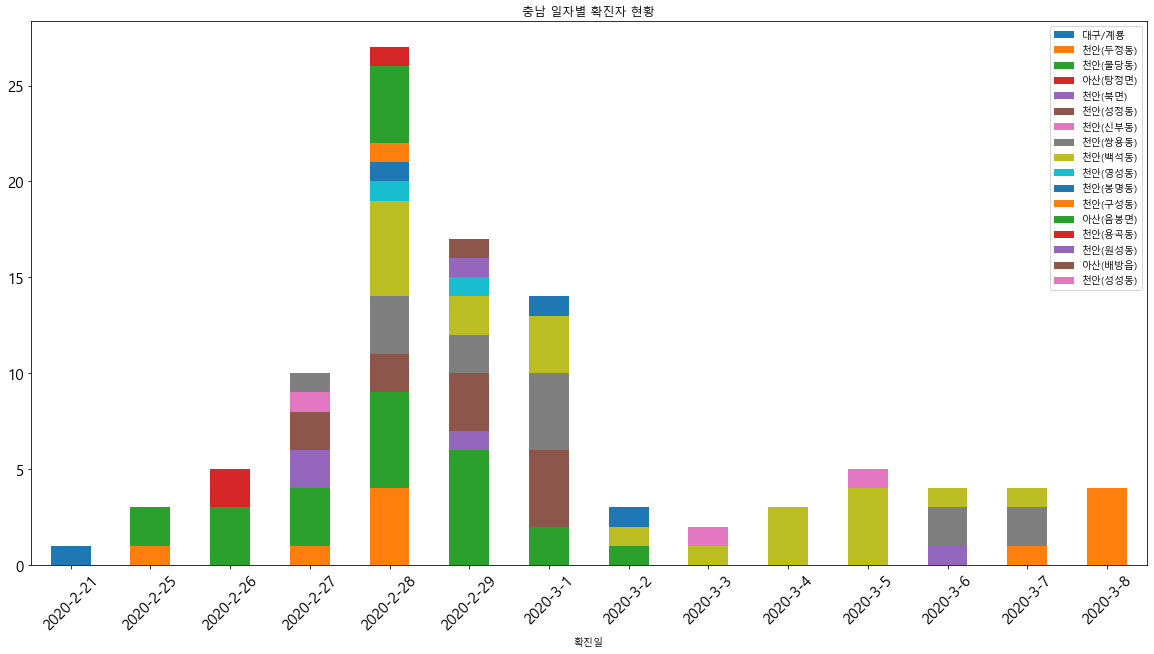

In [49]:
plt.figure(figsize=(20,10))
df_time1.plot.bar(stacked=True,figsize=(20,10),title='충남 일자별 확진자 현황',fontsize=15, rot=45)

In [37]:
df.to_csv('천안코로나.csv',encoding='utf-8-sig')